In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors
from copy import deepcopy

# Parameters from the paper
x_c = 2
x_c1 = 3.2
x_c2 = 4
a = 5
b = 1
L=500
dt=0.1


## Necessary function


In [4]:
# Equation 5,6
def normal_velocity(Dx, x_c=x_c):
    return np.tanh(Dx - x_c) + np.tanh(x_c)

def night_velocity(Dx, x_c=x_c, x_c1=x_c1, x_c2=x_c2, a=a, b=b):
    V = np.zeros_like(Dx)
    mask1 = Dx < x_c1
    mask2 = (Dx >= x_c1) & (Dx < x_c2)
    mask3 = Dx >= x_c2
    V[mask1] = np.tanh(Dx[mask1] - x_c) + np.tanh(x_c)
    V[mask2] = a - Dx[mask2]
    V[mask3] = b 
    return V

def normal_velocity_derivative(Dx, x_c=x_c):
    '''
    Derivative of normal optimal velocity function
    V(Δx) = tanh(Δx - x_c) + tanh(x_c)
    V'(Δx) = sech²(Δx - x_c) = 1 - tanh²(Δx - x_c)
    '''
    return 1 - np.tanh(Dx - x_c)**2

def night_velocity_derivative(Dx, x_c=x_c, x_c1=x_c1, x_c2=x_c2):
    '''
    Derivative of night traffic optimal velocity function
    For Dx < x_c1: V'(Δx) = sech²(Δx - x_c) = 1 - tanh²(Δx - x_c)
    For x_c1 < Dx < x_c2: For V(Δx) = a - Δx, the derivative is V'(Δx) = -1 (since 'a' is constant)
    For Dx > x_c2: V'(Δx) = 0
    V'(Δx) < κ/2 + λ to get model linear stability
    '''
    V_prime = np.zeros_like(Dx)

    mask1 = Dx < x_c1
    V_prime[mask1] = 1 - np.tanh(Dx[mask1] - x_c)**2

    mask2 = (Dx >= x_c1) & (Dx < x_c2)
    V_prime[mask2] = -1
    
    mask3 = Dx >= x_c2
    V_prime[mask3] = 0  
    return V_prime

def get_headways(positions,N, L=500):
    """Calculate headways with periodic boundary conditions"""
    headways = np.zeros(len(positions))
    for i in range(N):
        leader = (i - 1) % N
        delta_x = positions[leader] - positions[i]
        delta_x=delta_x%L # periodic
        headways[i] = delta_x
    return headways

def update_with_perturbation(x,v,N,kappa, lambda_param,use_night_driving,
                             perturbation_active,perturbation_counter,vehicle_stopped, perturbed_vehicles,n_dec,deceleration=1,A=0.1):
    """Update system with perturbation logic"""
    
    '''Calculate a following Eq.1'''
    headways = get_headways(x,N)
    accelerations = np.zeros(N)
    for i in range(N):
        prev_idx = (i - 1) % N     #-1=149=last
        headway = headways[i]
    # FVD model acceleration (Equation 1). Chỉ ban đêm mới có pertubation
        if use_night_driving:
            optimal_velocity = night_velocity(np.array([headway]))[0]
        else: 
            optimal_velocity = normal_velocity(np.array([headway]))[0]
        velocity_diff = v[prev_idx] - v[i]
        accelerations[i] = (kappa * (optimal_velocity - v[i]) + lambda_param * velocity_diff)
    
    '''Apply perturbation to specific vehicle, fix a and v'''
    if perturbation_active and perturbation_counter < n_dec:
        for pv in perturbed_vehicles:
            if not vehicle_stopped:
                accelerations[pv] = -deceleration
                # Check if vehicle will reach zero velocity
                new_velocity = (v[pv] + accelerations[pv] * dt)    # -1 mỗi đelta t
                
                if new_velocity <= 0:
                        v[pv] = 0
                        vehicle_stopped = True
            else:
                # Vehicle remains stopped for remaining time steps
                accelerations[pv] = 0
                v[pv] = 0
            
        perturbation_counter += 1
        if perturbation_counter >= n_dec:
            perturbation_active = False
    
    v_old = v.copy()
    v_max = night_velocity(np.array([3.2]))[0] if use_night_driving else normal_velocity(np.array([10.0]))[0]
    '''Update velocities Eq.3 (except for stopped vehicle during perturbation) or Eq.7,8'''
    for i in range(N):
        if A == 0:
            if not (perturbation_active and i in perturbed_vehicles and vehicle_stopped):
                v[i] += accelerations[i] * dt
                v[i] = max(0, v[i])
        else: 
            if not (perturbation_active and i in perturbed_vehicles and vehicle_stopped):
                # Eq. 7: Add deterministic acceleration and random noise
                random_noise = (np.random.uniform(-0.5, 0.5)) * A
                v_new_temp = v[i] + accelerations[i] * dt + random_noise
                # Eq. 8: Ensure velocity stays within bounds [0, v_max]
                v[i] = min(max(0, v_new_temp), v_max)
    '''Update positions Eq.4 or Eq.9'''
    for i in range(N):
        if A==0:
            x[i] += v[i] * dt + 0.5 * accelerations[i] * (dt**2)
            x[i] = x[i] % L  # Periodic boundary
        else:         
            x[i] += 0.5 * (v_old[i] + v[i]) * dt
            x[i] = x[i] % L  # Periodic boundary
    return x,v,perturbation_active, vehicle_stopped, perturbation_counter


## Fig 1

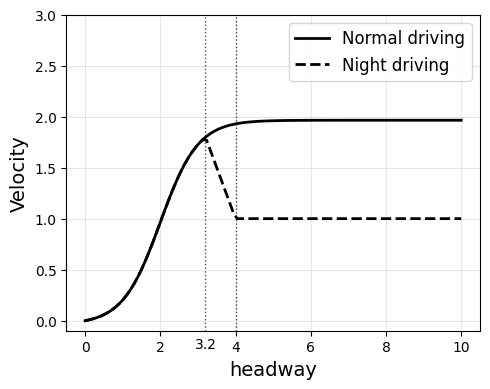

In [3]:
# Create headway range
headway = np.linspace(0, 10, 100)

V_normal = normal_velocity(headway, x_c)
V_night = night_velocity(headway, x_c, x_c1, x_c2, a, b)


plt.figure(figsize=(5,4))
plt.plot(headway, V_normal, 'k-', linewidth=2, label='Normal driving')
plt.plot(headway, V_night, 'k--', linewidth=2, label='Night driving')

plt.axvline(x=x_c1, color='black', linestyle=':', alpha=0.7, linewidth=1)
plt.axvline(x=x_c2, color='black', linestyle=':', alpha=0.7, linewidth=1)
plt.text(x_c1, -0.16, f'{x_c1}', ha='center', va='top', color='black', fontsize=10)

# Formatting
plt.xlabel('headway', fontsize=14)
plt.ylabel('Velocity', fontsize=14)
plt.ylim(top=3.0)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
# plt.title('Optimal Velocity Functions: Normal vs Night Driving', fontsize=14)
plt.tight_layout()
plt.show()

## Fig 2


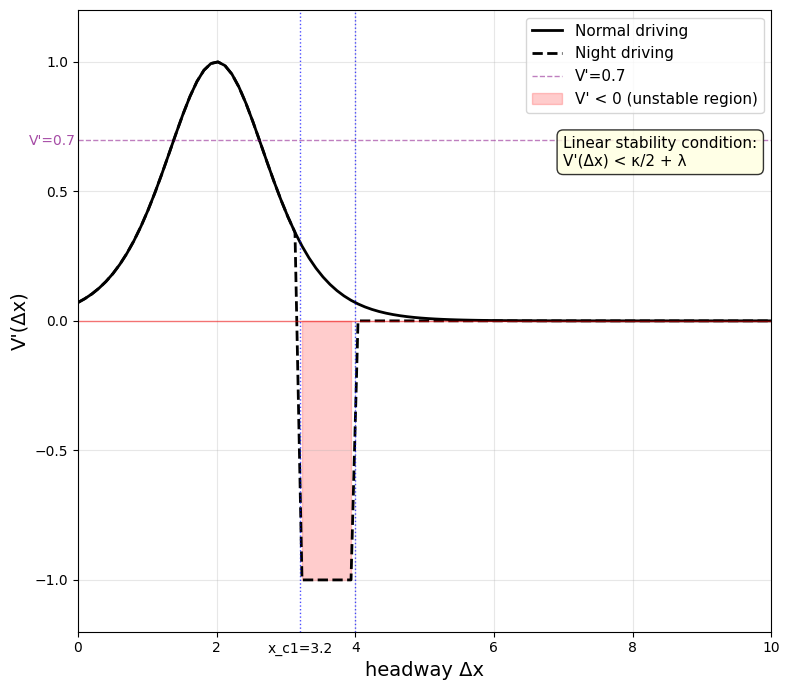

In [4]:
V_prime_normal = normal_velocity_derivative(headway)
V_prime_night = night_velocity_derivative(headway)

plt.figure(figsize=(8, 7))
plt.plot(headway, V_prime_normal, 'k-', linewidth=2, label="Normal driving")
plt.plot(headway, V_prime_night, 'k--', linewidth=2, label="Night driving")

plt.axvline(x=x_c1, color='blue', linestyle=':', alpha=0.7, linewidth=1)
plt.axvline(x=x_c2, color='blue', linestyle=':', alpha=0.7, linewidth=1)
plt.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)
plt.axhline(y=0.7,color='purple', linestyle='--', alpha=0.5, linewidth=1, label="V'=0.7")
plt.text(x_c1,-1.24, f'x_c1={x_c1}', ha='center', va='top', color='black', fontsize=10)
plt.text(x=-0.7, y=0.7-0.02,   # x là vị trí ngang (tùy chỉnh theo trục x), y là hơi lệch lên so với y=0.7
         s="V'=0.7",           
        color='purple',
        fontsize=10,
        alpha=0.7
)

# negative region for night driving
plt.fill_between(headway, V_prime_night, 0, where=(V_prime_night < 0), 
                 alpha=0.2, color='red', label='V\' < 0 (unstable region)')

# Add stability condition annotation
plt.text(7, 0.6, 'Linear stability condition:\nV\'(Δx) < κ/2 + λ', 
         fontsize=11, bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.8))

# Formatting
plt.xlabel('headway Δx', fontsize=14)
plt.ylabel("V'(Δx)", fontsize=14)
plt.xlim(0, 10)
plt.ylim(-1.2, 1.2)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
# plt.title("Derivative of Optimal Velocity Functions", fontsize=14)

plt.tight_layout()
plt.show()


## Fuction for fig 3,5,7,8

In [5]:
def simulate_clustering(x_min, x_max,N=150, kappa_local=1.0, lambda_param_local=0.5,apply_perturbation=False, L=L, dt=dt, T_max=2500, n_dec=0, deceleration=1.0,A=0.1):
    '''Change lambda, N,apply_perturb for Fig 3,5,7, 9'''
    '''Initialize vehicles in the density range x_min < Dx < x_max => unstable, clustering occurs'''
    print("INITIALIZATION ANALYSIS")
    initial_spacing = L / N
    if x_min > initial_spacing or initial_spacing >x_max:
        print("stable range")

    x = np.array([i * initial_spacing for i in range(N)])[::-1]
    initial_optimal_v = night_velocity(np.array([initial_spacing]))[0] 
    v = np.ones(N) * initial_optimal_v

    n_steps = int(T_max / dt)
    n_save = 2  # save steps for plotting

    time_points = []
    position_data = []


    if apply_perturbation:
        perturbation_active = True
        perturbation_counter = 0
        vehicle_stopped = False
        perturbation_vehicles = list(range(0, N, max(1, N//15)))[:1]
    else: 
        perturbation_active = False
        perturbation_counter = 0
        vehicle_stopped = False
        perturbation_vehicles = None
    print(f"N = {N}, κ = {kappa_local}, λ = {lambda_param_local}")
    print(f"Initial spacing ≈ {initial_spacing:.2f} (in range {x_c1}-{x_c2})")
    print('\n')

    for step in range(n_steps):
        t = step * dt
        x, v, perturbation_active, vehicle_stopped, perturbation_counter = update_with_perturbation(
            x=x, v=v, N=N, kappa=kappa_local, lambda_param=lambda_param_local,
            use_night_driving=True,
            perturbation_active=perturbation_active,
            perturbation_counter=perturbation_counter,
            vehicle_stopped=vehicle_stopped,
            perturbed_vehicles=perturbation_vehicles,
            n_dec=n_dec,
            deceleration=deceleration,
            A=A
        )
        if step % n_save == 0:
            time_points.append(t)
            position_data.append(x.copy())

    time_points = np.array(time_points)
    position_data = np.array(position_data)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    '''Top plot: Space-time diagram like Figure 3'''
    print("Creating space-time plot...")
    for t_idx, t in enumerate(time_points):
        positions = position_data[t_idx, :]
        # small dots to represent vehicles -> easier see
        ax1.scatter(positions, [t] * len(positions), c='black', s=1, alpha=0.3)

    ax1.set_xlabel('Position x', fontsize=12)
    ax1.set_ylabel('Time t', fontsize=12)
    # ax1.set_title(f'Space-Time Diagram - Night Driving Clustering (N={N}, κ={kappa}, λ={lambda_param})', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, L)

    '''Bottom plot: Alternative visualization showing vehicle trajectories'''
    print("Creating trajectory plot...")
    # few vehicles to avoid clutter
    step_size = max(1, N // 30)
    for i in range(0, N, step_size):
        vehicle_positions = position_data[:, i]
        ax2.plot(vehicle_positions, time_points, 'k-', linewidth=0.5, alpha=0.6)

    # Highlight specific vehicles
    highlight_vehicles = np.linspace(0, N-1, 8, dtype=int)
    colors = plt.cm.tab10(np.linspace(0, 1, len(highlight_vehicles)))

    for i, vehicle in enumerate(highlight_vehicles):
        vehicle_positions = position_data[:, vehicle]
        ax2.plot(vehicle_positions, time_points, color=colors[i], linewidth=1.5, 
                alpha=0.8, label=f'Vehicle {vehicle}')
        
    ax2.set_xlabel('Position x', fontsize=12)
    ax2.set_ylabel('Time t', fontsize=12)
    # ax2.set_title('Vehicle Trajectories Showing Cluster Formation', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()


    # Analyze final state
    final_positions = position_data[-1, :]
    final_velocities = v

    # Calculate final headways
    final_headways = np.zeros(N)
    for i in range(N):
        next_i = (i - 1) % N
        dx = final_positions[next_i] - final_positions[i]
        if dx < 0:
            dx += L
        final_headways[i] = dx


    print(f"\nAverage velocity: {np.mean(final_velocities):.3f}")
    print(f"Velocity std deviation: {np.std(final_velocities):.3f}")

    # Identify clusters (vehicles with large headways are cluster leaders)
    large_headways = final_headways > x_c2
    cluster_leaders = np.where(large_headways)[0]
    n_clusters = len(cluster_leaders)

    print(f"\nNumber of clusters (headways > {x_c2}): {n_clusters}")

    if n_clusters > 0:
        print(f"Leader vehicles have headway > x_c2 = {x_c2} move with velocity ≈ {b}")
        
        # Calculate cluster sizes
        if n_clusters > 1:
            cluster_sizes = []
            sorted_leaders = np.sort(cluster_leaders)
            for i in range(n_clusters):
                next_leader = sorted_leaders[(i + 1) % n_clusters]
                if next_leader > sorted_leaders[i]:
                    size = next_leader - sorted_leaders[i]
                else:
                    size = (N - sorted_leaders[i]) + next_leader
                cluster_sizes.append(size)
            print(f"Cluster sizes: {cluster_sizes}")
    else:
        print("No clear clustering observed - try different parameters")

    '''Create a zoomed version focusing on clustering pattern (Figure 3 style plot)'''
    print("\nCreating detailed clustering visualization...")

    # Find time range where clustering is most visible
    mid_time_idx = len(time_points) // 2
    zoom_start = max(0, mid_time_idx - 40)
    zoom_end = min(len(time_points), mid_time_idx + 40)

    plt.figure(figsize=(14, 8))

    for t_idx in range(zoom_start, zoom_end):
        t = time_points[t_idx]
        positions = position_data[t_idx, :]
        # Plot vehicles as points
        plt.scatter(positions, [t] * len(positions), c='black', s=2, alpha=0.8)
    plt.xlabel('Position x', fontsize=14)
    plt.ylabel('Time t', fontsize=14)
    # plt.title('Detailed View of Clustering Pattern (Night Driving)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    


## Fig 3

INITIALIZATION ANALYSIS
N = 150, κ = 1.0, λ = 0.5
Initial spacing ≈ 3.33 (in range 3.2-4)


Creating space-time plot...
Creating trajectory plot...


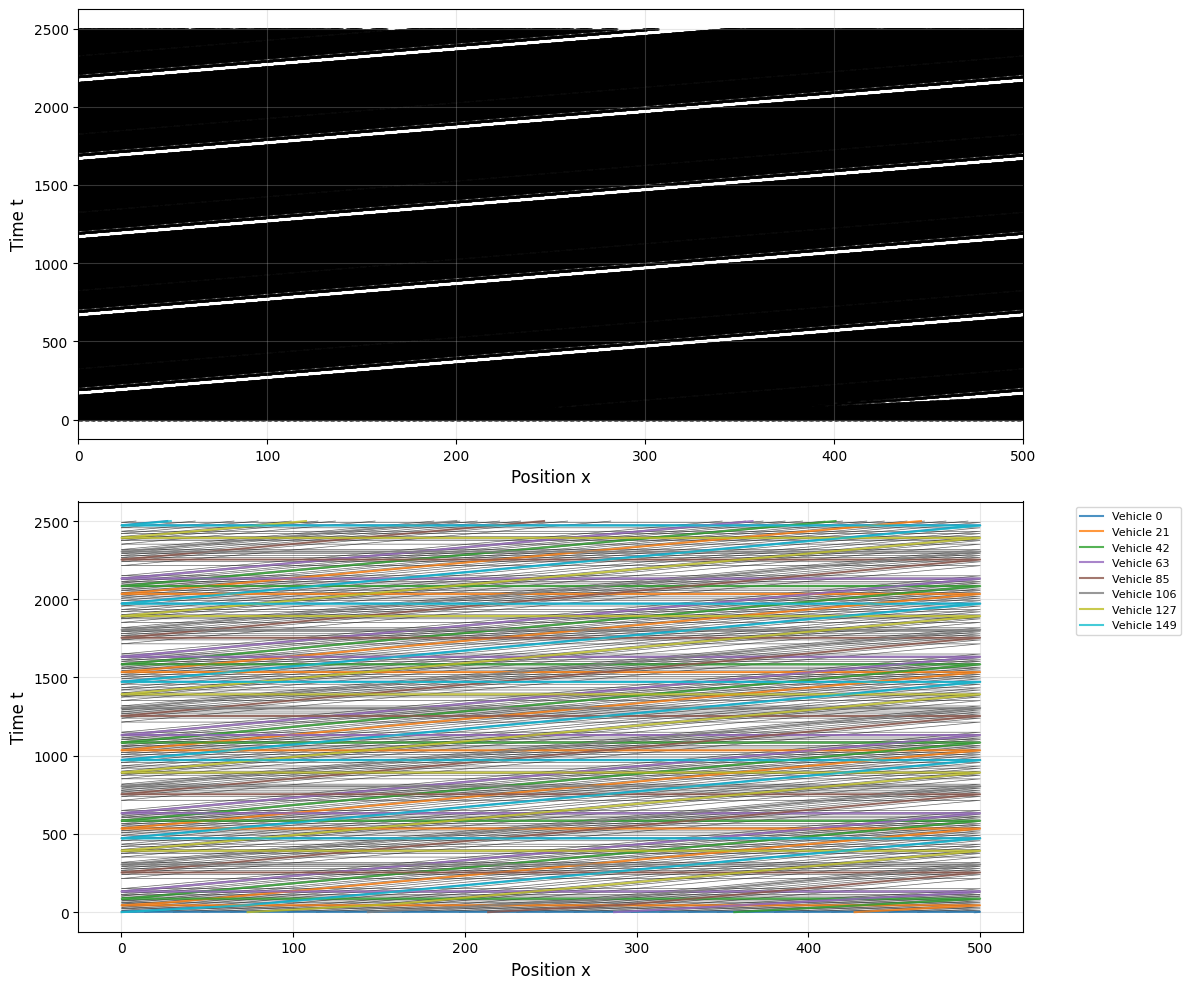


Average velocity: 1.000
Velocity std deviation: 0.000

Number of clusters (headways > 4): 37
Leader vehicles have headway > x_c2 = 4 move with velocity ≈ 1
Cluster sizes: [2, 2, 2, 2, 6, 4, 8, 11, 9, 9, 13, 4, 2, 2, 2, 2, 6, 4, 8, 8, 3, 2, 2, 2, 2, 2, 6, 4, 2, 2, 2, 5, 2, 2, 2, 2, 2]

Creating detailed clustering visualization...


/tmp/ipykernel_28365/2192463760.py:157: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


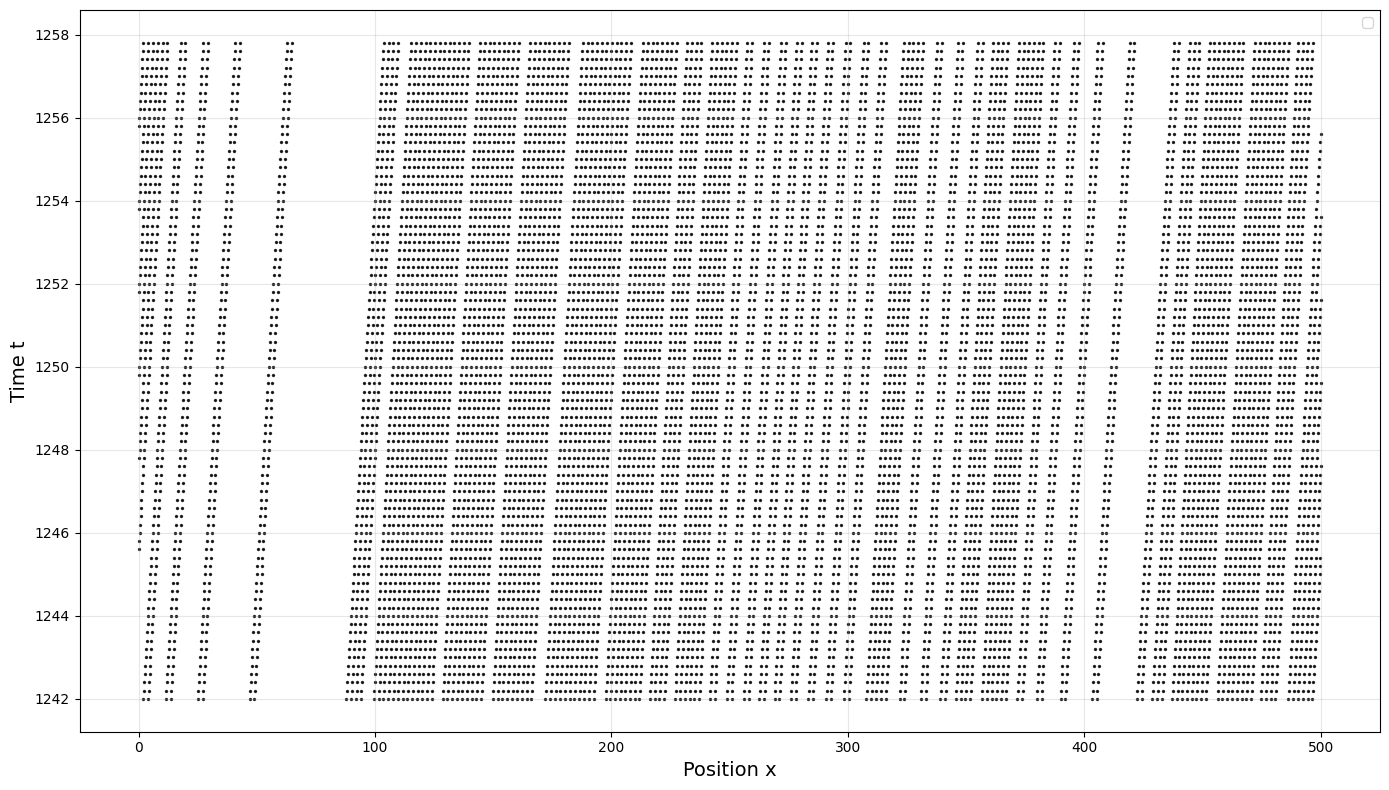

In [6]:
simulate_clustering(x_c1, x_c2,N=150, kappa_local=1.0, lambda_param_local=0.5, apply_perturbation=False,T_max=2500,n_dec=0,A=0)

## Function for Fig 4,6

In [9]:
def simulate_traffic(N,L,k,lamb, use_night_driving=True, apply_perturbation=False, T_max=250,n_dec=1,A=0):
    """
    Simulate traffic flow using FVD model
    Returns: density, flow
    """
    ''' 
    Initialize positions uniformly
    Theo paper, intial status là homogenous traffic, và xe vị trí càng to thì index càng bé( xe n là head của xe n+1))
    '''
    initial_spacing = L / N
    x = np.array([i * initial_spacing for i in range(N)])[::-1]   # reverse lại
    
    # Initialize velocities
    if use_night_driving:
        initial_v = night_velocity(np.array([initial_spacing]))[0]
    else:
        initial_v = normal_velocity(np.array([initial_spacing]))[0]
    
    # v = np.ones(N) * max(0.05, initial_v)  # Avoid zero initial velocity
    v = np.ones(N) * 0.05
    
    n_steps = int(T_max / dt)
    transient_steps=100   # for record value
    
    if apply_perturbation:
        perturbation_active = True
        perturbed_vehicles = list(range(0, N, max(1, N//15)))[:1]   # tức là xe index 0
        # perturbed_vehicles = list(random.randint(0, N-1))
        perturbation_counter = 0
        vehicle_stopped = False
    else:
        '''Normal without perturbation'''
        perturbation_active = False
        perturbed_vehicles = None
        perturbation_counter = 0
        vehicle_stopped = False
###################################################################################
    # Run simulation
    recorded_velocities = []
    for step in range(n_steps):
        x,v,perturbation_active,vehicle_stopped,perturbation_counter = update_with_perturbation(x=x,v=v,N=N,kappa=k, lambda_param=lamb, use_night_driving=use_night_driving,
                                                                                                perturbation_active=perturbation_active,perturbation_counter=perturbation_counter,
                                                                                                vehicle_stopped=vehicle_stopped, perturbed_vehicles=perturbed_vehicles,n_dec=n_dec,A=A) 
        
    # Calculate final density and flow
    density = N / L
    final_flow = density * np.mean(v)
    # avg_velocity = np.mean(recorded_velocities[transient_steps:])
    # final_flow = density * avg_velocity
    
    return density, final_flow
###################################################################################
def create_fundamental_diagram(N_max,L,k,lamb,n_dec=1):
    """Create Figure 4 - Fundamental diagram with three curves"""
    
    # Range of vehicle numbers to test different densities
    # N_values = np.arange(10, N_max, 15)  # From low to high density
    N_values = np.concatenate([np.arange(20, 50, 10),       # Very low density
                               np.arange(50, 300, 20),    # Medium density
                               np.arange(300, 500, 30)    # High density
                              ])
    
    densities_normal = []
    flows_normal = []
    densities_night = []
    flows_night = []
    densities_night_pert = []
    flows_night_pert = []
    
    print("Simulating traffic for different densities...")
    
    for i, N in enumerate(N_values):
        print(f"Progress: {i+1}/{len(N_values)} (N={N})")
        
        # Normal driving
        density_norm, flow_norm = simulate_traffic(N,L,k,lamb, use_night_driving=False, apply_perturbation=False,n_dec=n_dec)
        densities_normal.append(density_norm)
        flows_normal.append(flow_norm)
        
        # Night driving with small perturbations # SET T_MAX = 2500 OR Smaller
        density_night_p, flow_night_p = simulate_traffic(N,L,k,lamb, use_night_driving=True, apply_perturbation=True,T_max=2500,n_dec=n_dec)
        densities_night_pert.append(density_night_p)
        flows_night_pert.append(flow_night_p)
    

    # Convert to numpy arrays
    densities_normal = np.array(densities_normal)
    flows_normal = np.array(flows_normal)

    densities_night_pert = np.array(densities_night_pert)
    flows_night_pert = np.array(flows_night_pert)
    
    # Compute THEORETICAL NIGHT (dashed line) - NOT simulated!
    densities_night_theory = np.linspace(0.01, 0.99, 100)
    headways_theory = 1 / densities_night_theory
    flows_night_theory = densities_night_theory * night_velocity(headways_theory)
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot the three curves
    plt.plot(densities_normal, flows_normal, 'k-', linewidth=2, label='Normal driving', markersize=4)
    plt.plot(densities_night_theory, flows_night_theory, 'k--', linewidth=2, label='Night driving', markersize=4)
    plt.plot(densities_night_pert, flows_night_pert, 'k:', linewidth=2, label='Night driving (n_dec=1)', markersize=4)
    
    # Calculate key density points for night driving
    rho_c1 = 1.0 / x_c1  # κ_c1 in the paper
    rho_c2 = 1.0 / x_c2  # κ_c2 in the paper
    plt.axvline(rho_c1, color='black', linestyle=':', alpha=0.7, linewidth=1, label=f'κ_c1 = {rho_c1:.2f}')
    plt.axvline(rho_c2, color='black', linestyle=':', alpha=0.7, linewidth=1, label=f'κ_c2 = {rho_c2:.2f}')
    plt.text(rho_c2, -0.01, f'κ_c2', ha='center', va='top', color='black', fontsize=10)
    plt.text(rho_c1, 0.82, f'κ_c1', ha='center', va='top', color='black', fontsize=10)

    # Formatting
    plt.xlabel('Density κ', fontsize=14)
    plt.ylabel('Flow Q', fontsize=14)
    plt.title(f'Fundamental Diagram (κ={k}, λ={lamb})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    plt.xlim(0,1)
    plt.ylim(0, 0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Print some analysis
    print("\nAnalysis Results:")
    print(f"Critical densities: κ_c1 = {rho_c1:.5f}, κ_c2 = {rho_c2:.5f}")
    
    return (densities_normal, flows_normal, densities_night, flows_night, 
            densities_night_pert, flows_night_pert)

## Fig 4

Creating Figure 4 - Fundamental Diagram
1.0 0.2
Simulating traffic for different densities...
Progress: 1/33 (N=10)
Progress: 2/33 (N=25)
Progress: 3/33 (N=40)
Progress: 4/33 (N=55)
Progress: 5/33 (N=70)
Progress: 6/33 (N=85)
Progress: 7/33 (N=100)
Progress: 8/33 (N=115)
Progress: 9/33 (N=130)
Progress: 10/33 (N=145)
Progress: 11/33 (N=160)
Progress: 12/33 (N=175)
Progress: 13/33 (N=190)
Progress: 14/33 (N=205)
Progress: 15/33 (N=220)
Progress: 16/33 (N=235)
Progress: 17/33 (N=250)
Progress: 18/33 (N=265)
Progress: 19/33 (N=280)
Progress: 20/33 (N=295)
Progress: 21/33 (N=310)
Progress: 22/33 (N=325)
Progress: 23/33 (N=340)
Progress: 24/33 (N=355)
Progress: 25/33 (N=370)
Progress: 26/33 (N=385)
Progress: 27/33 (N=400)
Progress: 28/33 (N=415)
Progress: 29/33 (N=430)
Progress: 30/33 (N=445)
Progress: 31/33 (N=460)
Progress: 32/33 (N=475)
Progress: 33/33 (N=490)


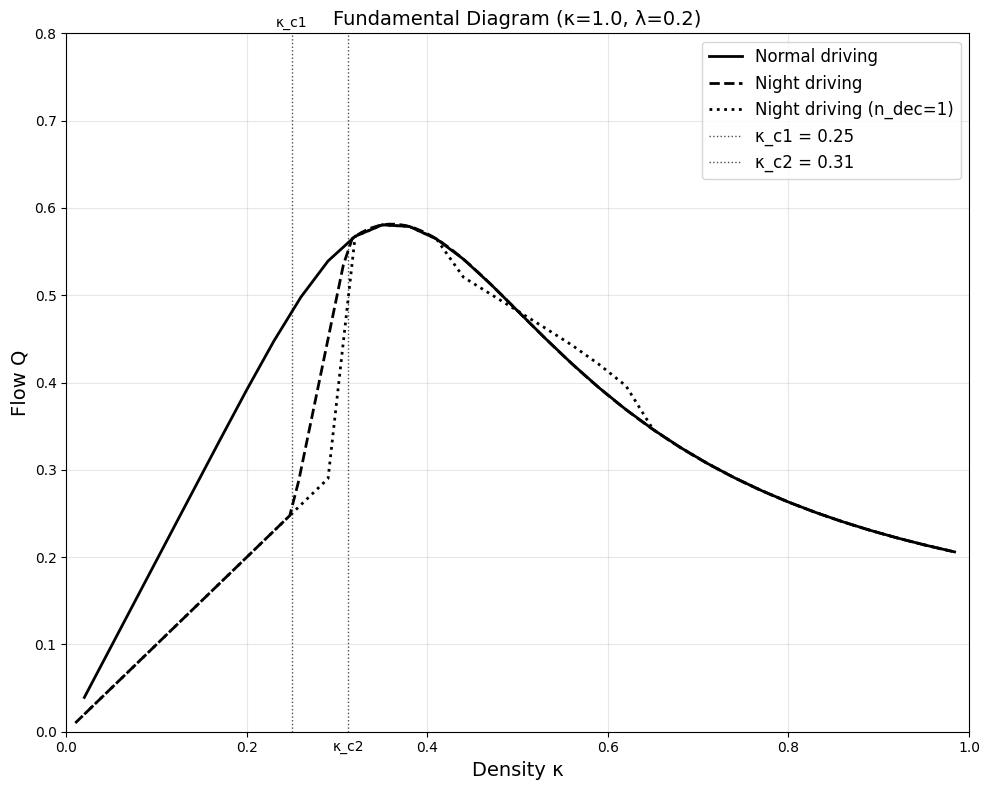


Analysis Results:
Critical densities: κ_c1 = 0.25000, κ_c2 = 0.31250


In [8]:
kappa = 1.0
lambda_param = 0.2
print("Creating Figure 4 - Fundamental Diagram")

run_full_simulation = True 

if run_full_simulation:
    print(kappa, lambda_param)
    results = create_fundamental_diagram(N_max=501,L=500,k=kappa,lamb=lambda_param, n_dec=1)

## Fig 5


INITIALIZATION ANALYSIS
N = 250, κ = 1.0, λ = 0.2
Initial spacing ≈ 2.00 (in range 3.2-4)


Creating space-time plot...
Creating trajectory plot...


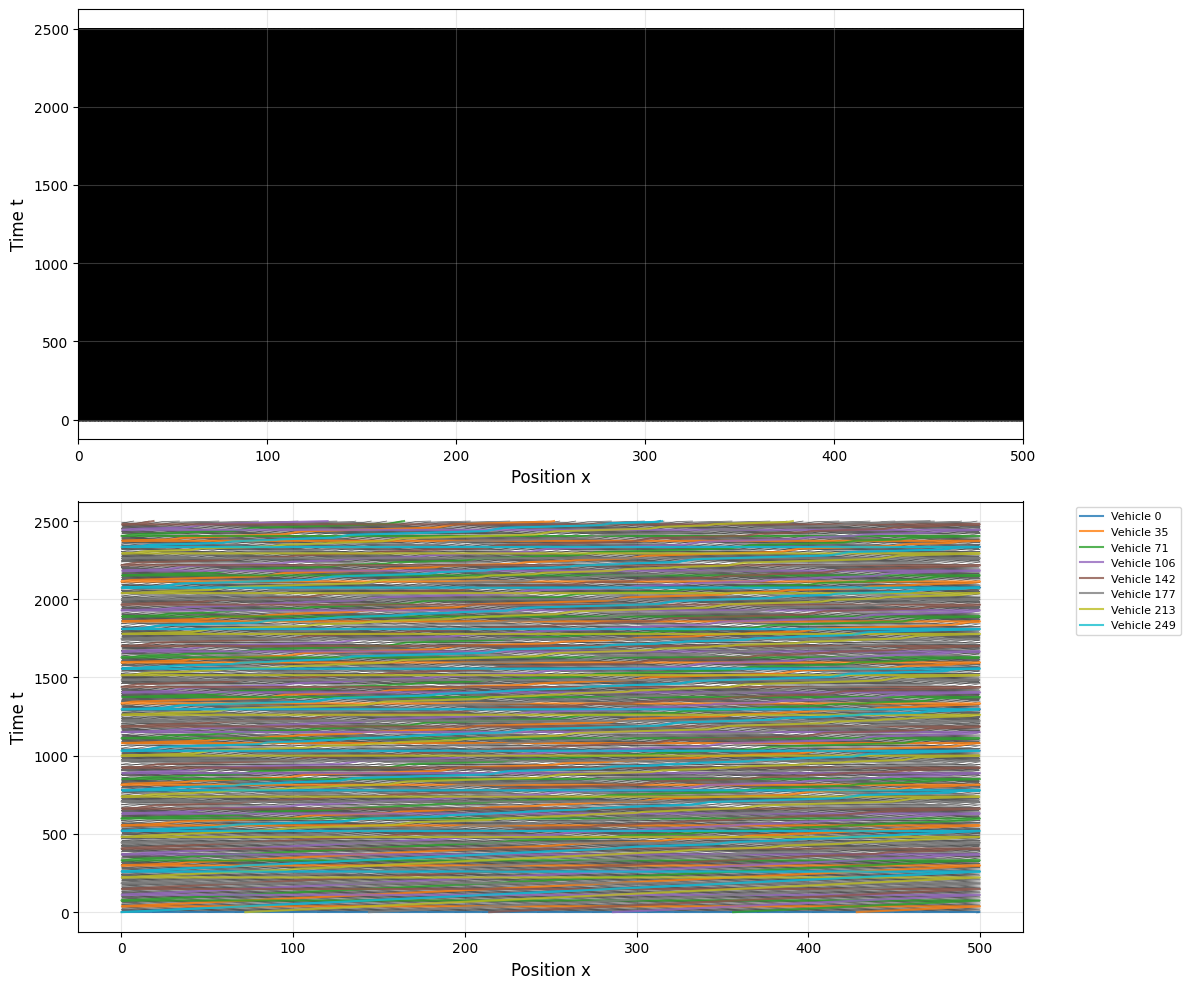


Average velocity: 0.964
Velocity std deviation: 0.647

Number of clusters (headways > 4): 0
No clear clustering observed - try different parameters

Creating detailed clustering visualization...


/tmp/ipykernel_921208/189617971.py:174: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


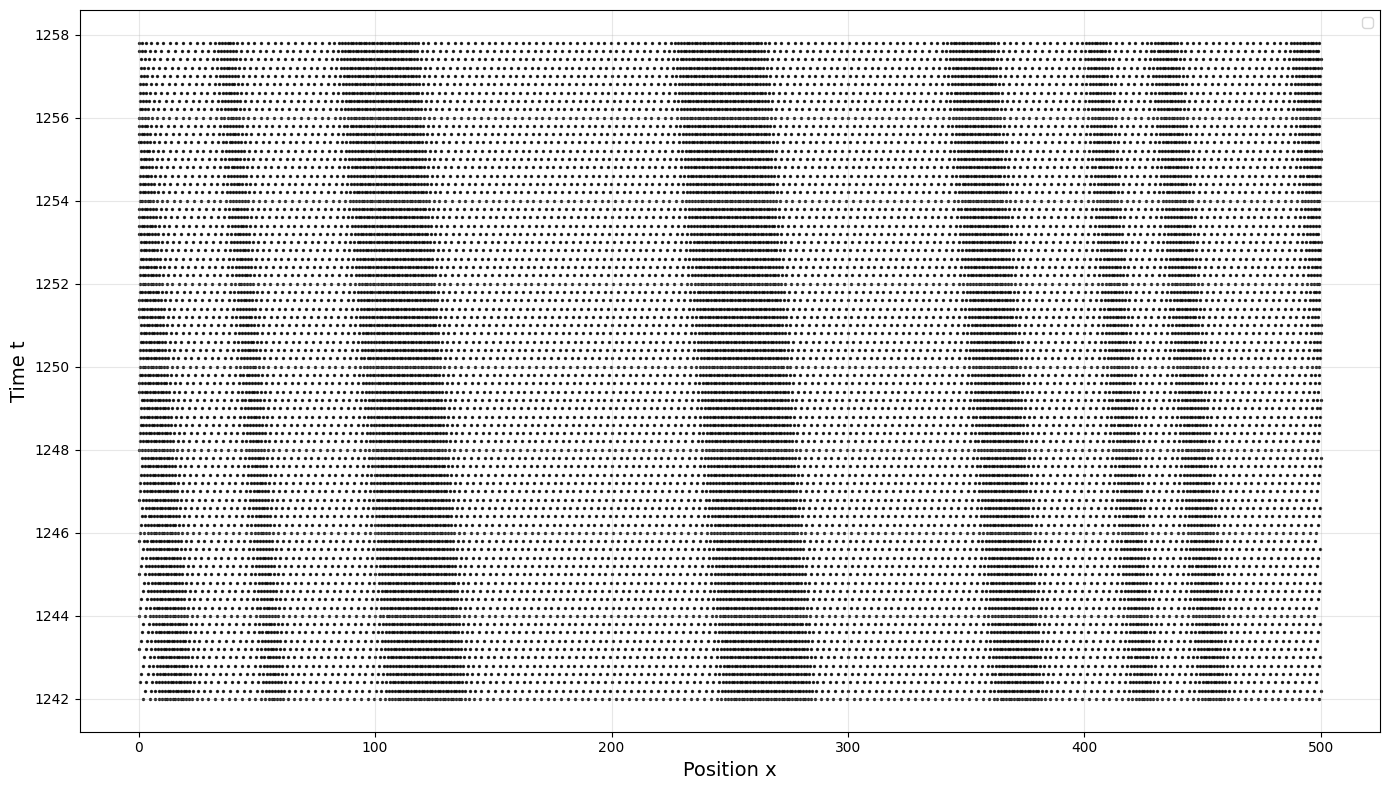

In [6]:
N = 250  # number of vehicles
kappa = 1.0  
lambda_param = 0.2
# nhìn paper đoán giá trị :))
x_c4=1/0.65
x_c3 =1/0.4
simulate_clustering(x_c4, x_c3,N=N, kappa_local=kappa, lambda_param_local=lambda_param, apply_perturbation=True, T_max=2500, n_dec=1)

## Fig 6

Creating Figure 6 - Fundamental Diagram
1.0 0.1
Simulating traffic for different densities...
Progress: 1/33 (N=10)
Progress: 2/33 (N=25)
Progress: 3/33 (N=40)
Progress: 4/33 (N=55)
Progress: 5/33 (N=70)
Progress: 6/33 (N=85)
Progress: 7/33 (N=100)
Progress: 8/33 (N=115)
Progress: 9/33 (N=130)
Progress: 10/33 (N=145)
Progress: 11/33 (N=160)
Progress: 12/33 (N=175)
Progress: 13/33 (N=190)
Progress: 14/33 (N=205)
Progress: 15/33 (N=220)
Progress: 16/33 (N=235)
Progress: 17/33 (N=250)
Progress: 18/33 (N=265)
Progress: 19/33 (N=280)
Progress: 20/33 (N=295)
Progress: 21/33 (N=310)
Progress: 22/33 (N=325)
Progress: 23/33 (N=340)
Progress: 24/33 (N=355)
Progress: 25/33 (N=370)
Progress: 26/33 (N=385)
Progress: 27/33 (N=400)
Progress: 28/33 (N=415)
Progress: 29/33 (N=430)
Progress: 30/33 (N=445)
Progress: 31/33 (N=460)
Progress: 32/33 (N=475)
Progress: 33/33 (N=490)


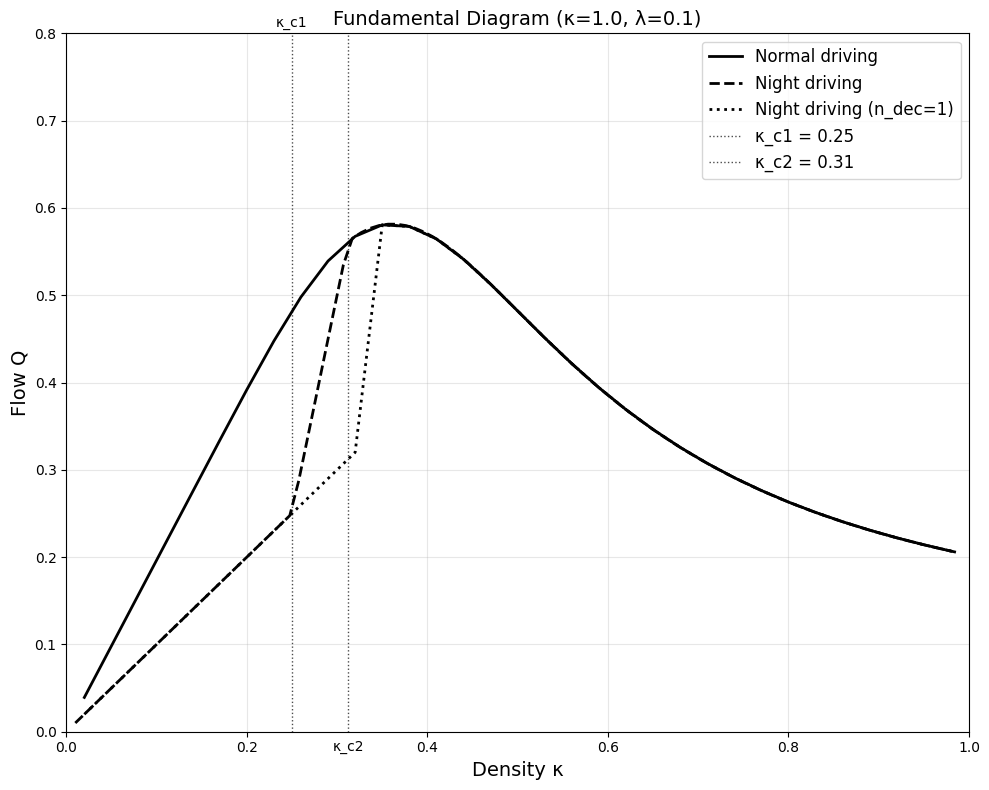


Analysis Results:
Critical densities: κ_c1 = 0.25000, κ_c2 = 0.31250


In [5]:
kappa = 1.0
lambda_param = 0.1
print("Creating Figure 6 - Fundamental Diagram")

run_full_simulation = True 

if run_full_simulation:
    print(kappa, lambda_param)
    results = create_fundamental_diagram(N_max=501,L=500,k=kappa,lamb=lambda_param, n_dec=1)

## Fig 7


INITIALIZATION ANALYSIS
N = 230, κ = 1.0, λ = 0.1
Initial spacing ≈ 2.17 (in range 3.2-4)


Creating space-time plot...
Creating trajectory plot...


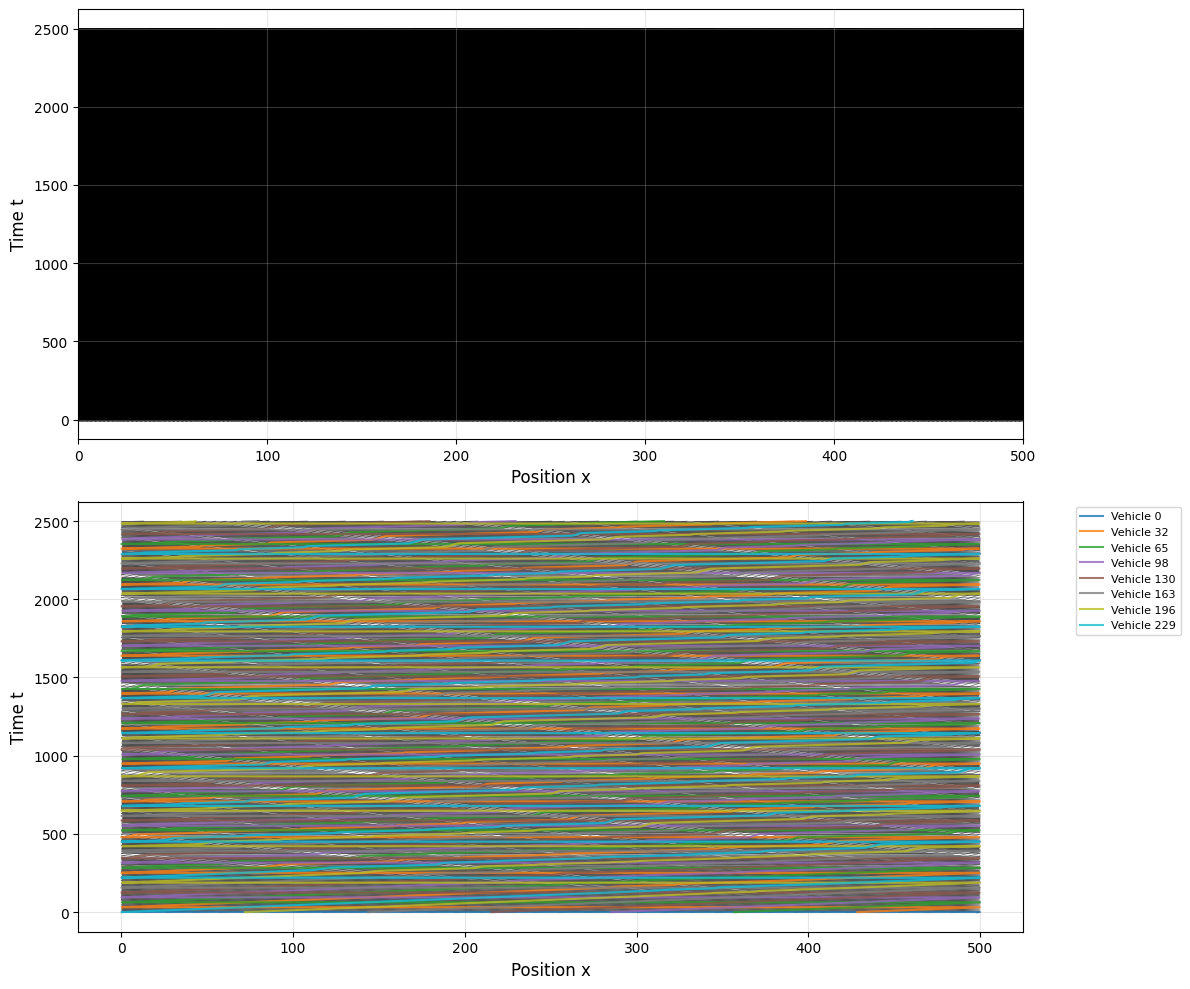


Average velocity: 1.087
Velocity std deviation: 0.758

Number of clusters (headways > 4): 0
No clear clustering observed - try different parameters

Creating detailed clustering visualization...


/tmp/ipykernel_921208/189617971.py:174: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


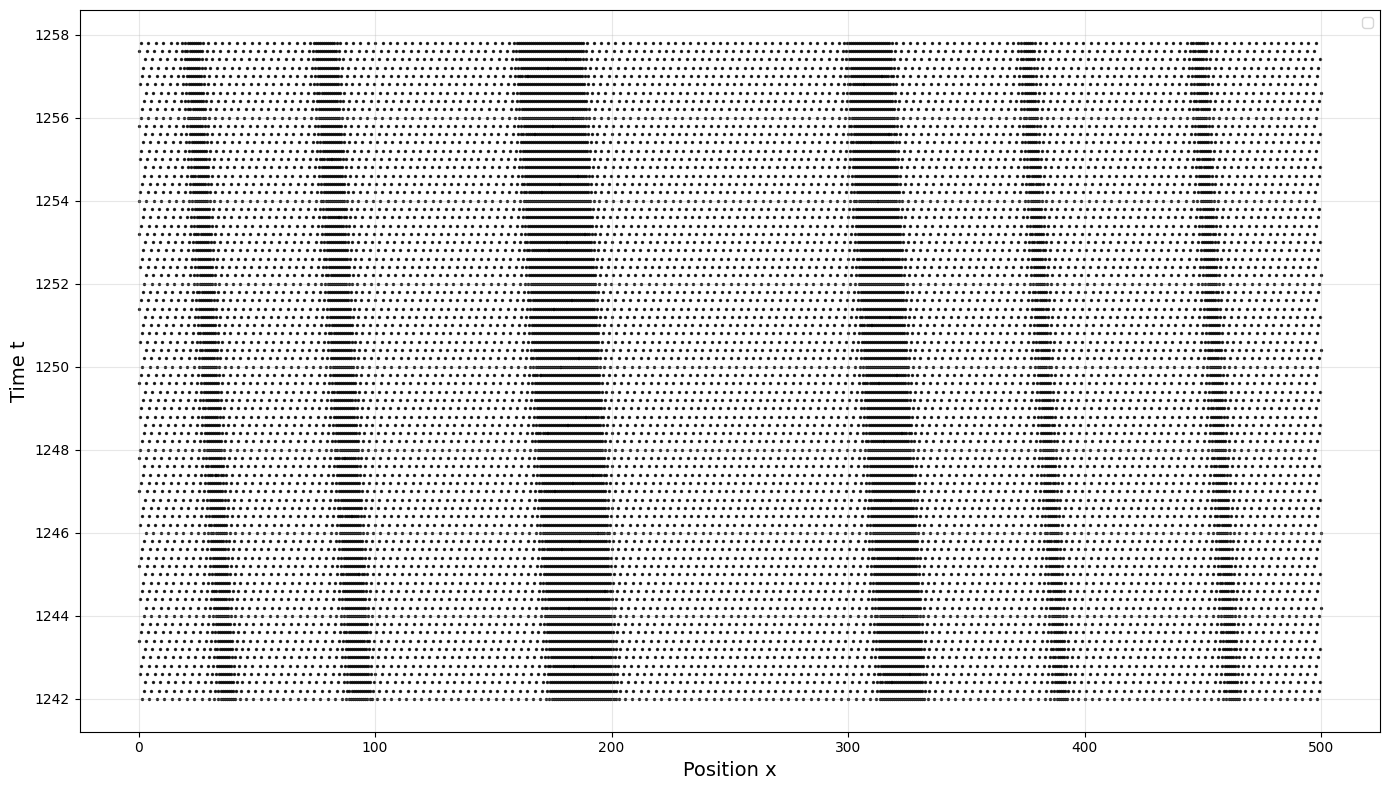

In [4]:
N = 230  # number of vehicles
kappa = 1.0  
lambda_param = 0.1
x_c7=1/0.49  # (nhìn hình paper đoán giá trị :)
x_c0 =1/0.01
simulate_clustering(x_c7, x_c0,N=N, kappa_local=kappa, lambda_param_local=lambda_param, apply_perturbation=True, T_max=2500, n_dec=1)

Creating Figure 10 - Fundamental Diagram
1.0 0.5
Simulating traffic for different densities...
Progress: 1/33 (N=10)
Progress: 2/33 (N=25)
Progress: 3/33 (N=40)
Progress: 4/33 (N=55)
Progress: 5/33 (N=70)
Progress: 6/33 (N=85)
Progress: 7/33 (N=100)
Progress: 8/33 (N=115)
Progress: 9/33 (N=130)
Progress: 10/33 (N=145)
Progress: 11/33 (N=160)
Progress: 12/33 (N=175)
Progress: 13/33 (N=190)
Progress: 14/33 (N=205)
Progress: 15/33 (N=220)
Progress: 16/33 (N=235)
Progress: 17/33 (N=250)
Progress: 18/33 (N=265)
Progress: 19/33 (N=280)
Progress: 20/33 (N=295)
Progress: 21/33 (N=310)
Progress: 22/33 (N=325)
Progress: 23/33 (N=340)
Progress: 24/33 (N=355)
Progress: 25/33 (N=370)
Progress: 26/33 (N=385)
Progress: 27/33 (N=400)
Progress: 28/33 (N=415)
Progress: 29/33 (N=430)
Progress: 30/33 (N=445)
Progress: 31/33 (N=460)
Progress: 32/33 (N=475)
Progress: 33/33 (N=490)


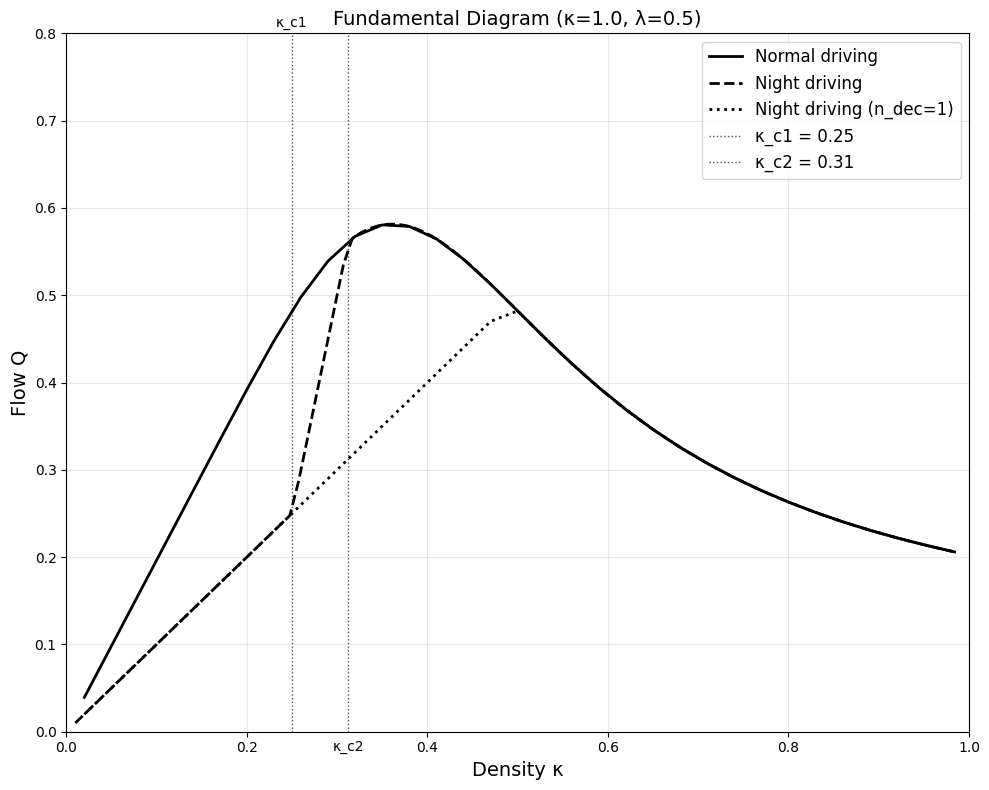


Analysis Results:
Critical densities: κ_c1 = 0.25000, κ_c2 = 0.31250


In [14]:
kappa = 1.0
lambda_param = 0.5
print("Creating Figure 10 - Fundamental Diagram")

run_full_simulation = True 

if run_full_simulation:
    print(kappa, lambda_param)
    results = create_fundamental_diagram(N_max=501,L=500,k=kappa,lamb=lambda_param, n_dec=80)

## Fig 12

Creating Figure 12 - Fundamental Diagram
1.0 0.2
Simulating traffic for different densities...
Progress: 1/33 (N=10)
Progress: 2/33 (N=25)
Progress: 3/33 (N=40)
Progress: 4/33 (N=55)
Progress: 5/33 (N=70)
Progress: 6/33 (N=85)
Progress: 7/33 (N=100)
Progress: 8/33 (N=115)
Progress: 9/33 (N=130)
Progress: 10/33 (N=145)
Progress: 11/33 (N=160)
Progress: 12/33 (N=175)
Progress: 13/33 (N=190)
Progress: 14/33 (N=205)
Progress: 15/33 (N=220)
Progress: 16/33 (N=235)
Progress: 17/33 (N=250)
Progress: 18/33 (N=265)
Progress: 19/33 (N=280)
Progress: 20/33 (N=295)
Progress: 21/33 (N=310)
Progress: 22/33 (N=325)
Progress: 23/33 (N=340)
Progress: 24/33 (N=355)
Progress: 25/33 (N=370)
Progress: 26/33 (N=385)
Progress: 27/33 (N=400)
Progress: 28/33 (N=415)
Progress: 29/33 (N=430)
Progress: 30/33 (N=445)
Progress: 31/33 (N=460)
Progress: 32/33 (N=475)
Progress: 33/33 (N=490)


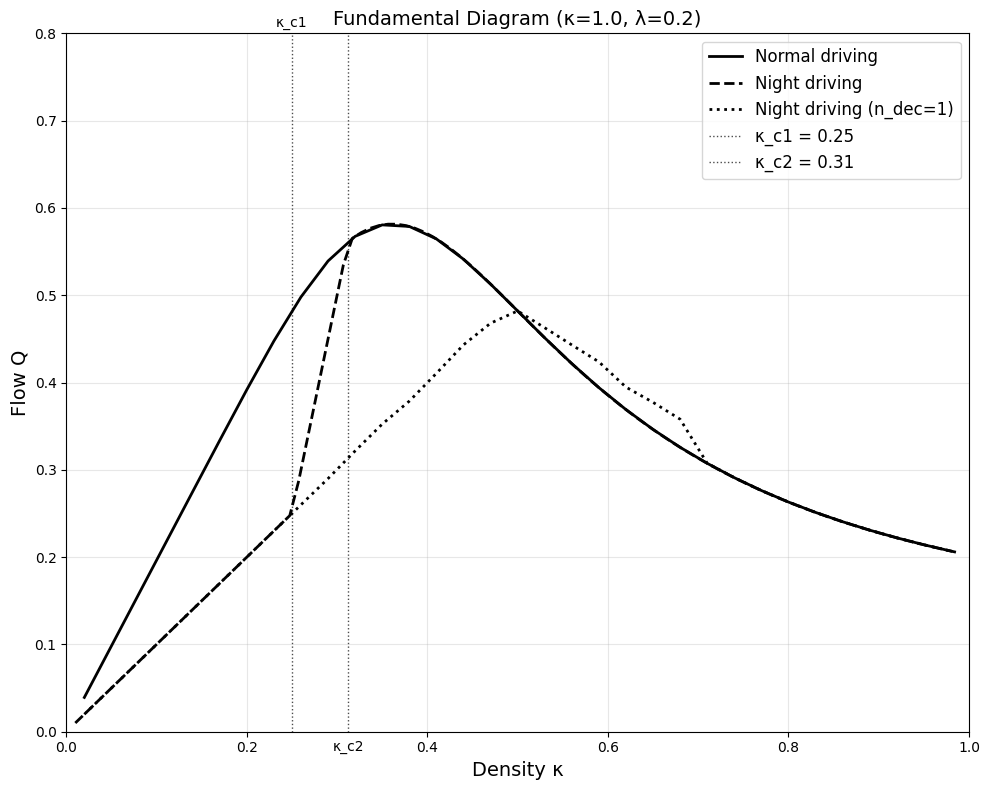


Analysis Results:
Critical densities: κ_c1 = 0.25000, κ_c2 = 0.31250


In [16]:
kappa = 1.0
lambda_param = 0.2
print("Creating Figure 12 - Fundamental Diagram")

run_full_simulation = True 

if run_full_simulation:
    print(kappa, lambda_param)
    results = create_fundamental_diagram(N_max=501,L=500,k=kappa,lamb=lambda_param, n_dec=80)

## Fig 14


Creating Figure 10 - Fundamental Diagram
1.0 0.1
Simulating traffic for different densities...
Progress: 1/33 (N=10)
Progress: 2/33 (N=25)
Progress: 3/33 (N=40)
Progress: 4/33 (N=55)
Progress: 5/33 (N=70)
Progress: 6/33 (N=85)
Progress: 7/33 (N=100)
Progress: 8/33 (N=115)
Progress: 9/33 (N=130)
Progress: 10/33 (N=145)
Progress: 11/33 (N=160)
Progress: 12/33 (N=175)
Progress: 13/33 (N=190)
Progress: 14/33 (N=205)
Progress: 15/33 (N=220)
Progress: 16/33 (N=235)
Progress: 17/33 (N=250)
Progress: 18/33 (N=265)
Progress: 19/33 (N=280)
Progress: 20/33 (N=295)
Progress: 21/33 (N=310)
Progress: 22/33 (N=325)
Progress: 23/33 (N=340)
Progress: 24/33 (N=355)
Progress: 25/33 (N=370)
Progress: 26/33 (N=385)
Progress: 27/33 (N=400)
Progress: 28/33 (N=415)
Progress: 29/33 (N=430)
Progress: 30/33 (N=445)
Progress: 31/33 (N=460)
Progress: 32/33 (N=475)
Progress: 33/33 (N=490)


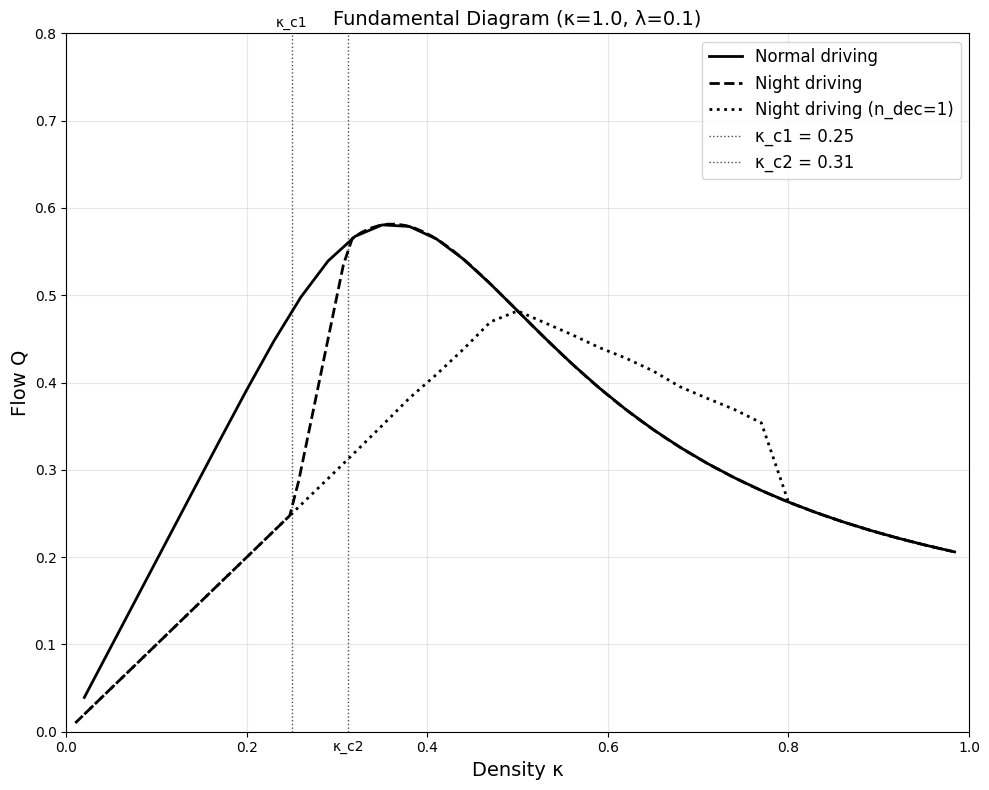


Analysis Results:
Critical densities: κ_c1 = 0.25000, κ_c2 = 0.31250


In [15]:
kappa = 1.0
lambda_param = 0.1
print("Creating Figure 10 - Fundamental Diagram")

run_full_simulation = True 

if run_full_simulation:
    print(kappa, lambda_param)
    results = create_fundamental_diagram(N_max=501,L=500,k=kappa,lamb=lambda_param, n_dec=80)

In [ ]:
kappa = 1.0
lambda_param = 0.2
print("Creating Figure 12 - Fundamental Diagram")

run_full_simulation = True 

if run_full_simulation:
    print(kappa, lambda_param)
    results = create_fundamental_diagram(N_max=501,L=500,k=kappa,lamb=lambda_param, n_dec=80,A=0.01)

In [ ]:
from numpy._typing._array_like import NDArray
import numpy as np
from typing import Callable, Literal, final, overload
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

SYSTEM_LENGTH = 500.0

def calculate_flow(positions_list: list[NDArray[np.float64]], velocities_list: list[NDArray[np.float64]]) -> float:
    """
    Calculate the flow of cars based on their positions and velocities.
    
    Parameters:
    - positions: array of car positions
    - velocities: array of car velocities
    
    Returns:
    - Flow rate (cars per second)
    """
    velocities = np.array(velocities_list, dtype=np.float64)
    positions = np.array(positions_list, dtype=np.float64)
    
    # Ensure positions are within the system length
    assert np.all(positions >= 0) and np.all(positions < SYSTEM_LENGTH), "Positions must be within the system length."

    # Calculate the average velocity
    avg_velocity = np.mean(velocities[100:]).item()
    
    # Calculate the density (cars per unit length)
    density = positions.shape[1] / SYSTEM_LENGTH
    
    # Flow is density times average velocity
    flow = density * avg_velocity
    
    # print(f"Average velocity: {avg_velocity}, Density: {density}, Flow: {flow}")
    return flow

def plot_traffic_raster(positions_list: list[NDArray[np.float64]], figsize: tuple[int, int] = (6, 8), filename:str='traffic_raster_plot.png') -> None:
    """
    Generate a binary traffic raster plot with correct axis mapping.

    Parameters:
    - positions_list: list of 1D arrays (or similarly shaped 2D),
      shaped (T, L), where each entry is 1 if a car is present, else 0.
    - system_length: total road length (0 to system_length) for x-axis.
    - cmap: colormap ('Greys' gives 0=black, 1=white).
    - figsize: output figure size.
    """
    positions_list = [positions_list[i] for i in range(0, len(positions_list), 2)]
    T = len(positions_list)
    L = int(SYSTEM_LENGTH)
    mat = np.zeros((T, L), dtype=np.uint8)  # create white background

    for t, pos in enumerate(positions_list):
        idx = np.rint(pos).astype(int)
        idx = np.clip(idx, 0, L - 1)  # keep positions in range
        mat[t, idx] = 1  # mark black for each car

    _, ax = plt.subplots(figsize=figsize)
    ax.imshow(mat, cmap='gray_r', origin='lower',
              interpolation='nearest', vmin=0, vmax=1)
    ax.set_xlabel('Position (0 to SYSTEM_LENGTH)')
    ax.set_ylabel('Time step')
    ax.set_title('Car positions over time')
    ax.set_xlim(-0.5, L - 0.5)
    ax.set_ylim(-0.5, T - 0.5)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)

def animate_simulation(positions_list:list[NDArray[np.float64]], interval:int=200):
    """
    Animate car positions over time.
    
    positions: ndarray of shape (T, N) — car positions at each time step
    colors: list or array of length N, specifying color for each car (optional)
    interval: delay between frames in ms
    """
    T = len(positions_list)
    N = positions_list[0].shape[0]
    y = np.zeros(N)  # y-axis all zeros (positions on a line)
    
    # Assign colors per car
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(N)]
    
    fig, ax = plt.subplots()
    # Initialize scatter with first frame
    scat = ax.scatter(positions_list[0], y, c=colors, s=100)

    # Setting consistent axis range
    all_positions = np.concatenate(positions_list)
    ax.set_xlim(all_positions.min() - 1, all_positions.max() + 1) # pyright: ignore[reportAny]
    ax.set_ylim(-1, 1)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Position along line")
    ax.set_title("Time step: 0")

    def update(frame): # pyright: ignore[reportMissingParameterType, reportUnknownParameterType]
        data = np.c_[positions_list[frame], y] # pyright: ignore[reportAny]
        scat.set_offsets(data)# pyright: ignore[reportAny]
        ax.set_title(f"Time step: {frame}")
        return scat,

    ani = FuncAnimation(fig, update, frames=T, interval=interval, blit=True)
    return ani

    
def FVD_acceleration(positions: NDArray[np.float64], velocities: NDArray[np.float64], optimal_velocity_function:Callable[[NDArray[np.float64]], NDArray[np.float64]], kappa:float, _lambda:float) -> NDArray[np.float64]:
    """
    Calculate the acceleration of each car based on their positions and velocities.
    
    Parameters:
    - positions: array of car positions
    - velocities: array of car velocities
    - optimal_velocity_function: function to calculate optimal velocity
    - kappa: sensitivity parameter for the optimal velocity
    - _lambda: sensitivity parameter for the relative velocity
    
    Returns:
    - Array of accelerations for each car
    """
    # Compute headways with periodic boundary conditions
    delta_x = np.roll(positions, -1) - positions
    # Assert that only one values is negative
    assert np.sum(delta_x < 0) == 1, "There should be exactly one negative headway."
    delta_x[delta_x < 0] += SYSTEM_LENGTH  # Adjust negative headway to wrap around
    # delta_x[-1] = SYSTEM_LENGTH - positions[-1] + positions[0]  # Wrap around for the last car
    # Compute optimal velocities for each headway
    V = optimal_velocity_function(delta_x)
    # Compute velocity differences between each vehicle and its leader
    delta_v = np.roll(velocities, -1) - velocities
    # Compute accelerations
    accelerations = kappa * (V - velocities) + _lambda * delta_v

    return accelerations

@final
class FVD_Simulator:
    def __init__(self, positions: NDArray[np.float64], velocities: NDArray[np.float64], optimal_velocity_function:Callable[[NDArray[np.float64]], NDArray[np.float64]], kappa: float, _lambda: float, delta_t: float=0.1):
        """
        Initialize the simulator with car positions, velocities, and an optimal velocity function.
        
        Parameters:
        - positions: initial positions of the cars
        - velocities: initial velocities of the cars
        - optimal_velocity_function: function to calculate optimal velocity
        """
        # Velocities must be non-negative
        assert np.all(velocities >= 0), "Velocities must be non-negative."
        # Positions must be within the system length
        assert np.all(positions >= 0) and np.all(positions < SYSTEM_LENGTH), "Positions must be within the system length."
        self.positions = positions
        self.velocities = velocities
        self.optimal_velocity_function = optimal_velocity_function
        self.kappa = kappa
        self._lambda = _lambda
        self.delta_t = delta_t
    def step(self):
        """
        Perform a single simulation step, updating positions and velocities.
        """
        # Calculate accelerations
        accelerations = FVD_acceleration(self.positions, self.velocities, self.optimal_velocity_function, self.kappa, self._lambda)
        # Update positions
        self.positions = np.maximum(self.positions, self.positions + self.velocities * self.delta_t + 0.5 * accelerations * self.delta_t**2)
        # Update velocities
        self.velocities += accelerations * self.delta_t
        # Ensure positions are circular around the system length
        self.velocities = np.clip(self.velocities, 0, None)  # Ensure non-negative velocities
        self.positions[self.positions >= SYSTEM_LENGTH] -= SYSTEM_LENGTH  # Wrap around positions
        
    @overload
    def run(self, steps: int, log_result:Literal[False]) -> None: ...
    
    @overload
    def run(self, steps: int, log_result:Literal[True]) -> tuple[list[NDArray[np.float64]], list[NDArray[np.float64]]]: ...
    
    def run(self, steps: int, log_result:bool=False) -> tuple[list[NDArray[np.float64]], list[NDArray[np.float64]]] | None:
        """
        Run the simulation for a specified number of steps.
        
        Parameters:
        - steps: number of simulation steps to run
        - log_result: whether to log the positions and velocities at each step
        
        Returns:
        - If log_result is True, returns a tuple of lists containing positions and velocities at each step.
        - If log_result is False, returns None.
        """
        if log_result:
            log_positions = [self.positions.copy()]
            log_velocities = [self.velocities.copy()]
            for _ in tqdm(range(steps), desc="Running FVD Simulation"):
                self.step()
                log_positions.append(self.positions.copy())
                log_velocities.append(self.velocities.copy())
            
            return log_positions, log_velocities
        else:
            for _ in tqdm(range(steps), desc="Running FVD Simulation"):
                self.step()
            return None

@final
class FVD_Simulator_with_Randomness:
    def __init__(self, positions: NDArray[np.float64], velocities: NDArray[np.float64], optimal_velocity_function:Callable[[NDArray[np.float64]], NDArray[np.float64]], kappa: float, _lambda: float, delta_t: float=0.1, A: float=0.1):
        """
        Initialize the simulator with car positions, velocities, and an optimal velocity function.
        
        Parameters:
        - positions: initial positions of the cars
        - velocities: initial velocities of the cars
        - optimal_velocity_function: function to calculate optimal velocity
        """
        # Velocities must be non-negative
        assert np.all(velocities >= 0), "Velocities must be non-negative."
        # Positions must be within the system length
        assert np.all(positions >= 0) and np.all(positions < SYSTEM_LENGTH), "Positions must be within the system length."
        self.positions = positions
        self.velocities = velocities
        self.optimal_velocity_function = optimal_velocity_function
        self.kappa = kappa
        self._lambda = _lambda
        self.delta_t = delta_t
        self.A = A # Amplitude of the randomness
    def step(self):
        """
        Perform a single simulation step, updating positions and velocities.
        """
        # Calculate accelerations
        accelerations = FVD_acceleration(self.positions, self.velocities, self.optimal_velocity_function, self.kappa, self._lambda)
        # Update velocities and positions
        old_velocities = self.velocities.copy()
        self.velocities += accelerations * self.delta_t + np.random.uniform(-0.5, 0.5, size=self.velocities.shape) * self.A  # Add randomness to velocities
        self.velocities = np.clip(np.clip(self.velocities, 0, None), None, self.optimal_velocity_function(np.array(3.2)).item())
        thres = np.roll(self.positions, -1)
        thres[thres < np.roll(thres, 1)] += SYSTEM_LENGTH  # Adjust positions for periodic boundary conditions
        self.positions = np.minimum(np.maximum(self.positions, self.positions + 0.5 * (old_velocities + self.velocities) * self.delta_t), thres)  # Update positions using average velocity
        
        self.positions[self.positions >= SYSTEM_LENGTH] -= SYSTEM_LENGTH  # Wrap around positions
        
    @overload
    def run(self, steps: int, log_result:Literal[False]) -> None: ...
    
    @overload
    def run(self, steps: int, log_result:Literal[True]) -> tuple[list[NDArray[np.float64]], list[NDArray[np.float64]]]: ...
    
    def run(self, steps: int, log_result:bool=False) -> tuple[list[NDArray[np.float64]], list[NDArray[np.float64]]] | None:
        """
        Run the simulation for a specified number of steps.
        
        Parameters:
        - steps: number of simulation steps to run
        - log_result: whether to log the positions and velocities at each step
        
        Returns:
        - If log_result is True, returns a tuple of lists containing positions and velocities at each step.
        - If log_result is False, returns None.
        """
        if log_result:
            log_positions = [self.positions.copy()]
            log_velocities = [self.velocities.copy()]
            for _ in tqdm(range(steps), desc="Running FVD Simulation"):
                self.step()
                log_positions.append(self.positions.copy())
                log_velocities.append(self.velocities.copy())
            
            return log_positions, log_velocities
        else:
            for _ in tqdm(range(steps), desc="Running FVD Simulation"):
                self.step()
            return None

@final
class FVD_Simulator_with_Perturbation:
    def __init__(self, positions: NDArray[np.float64], velocities: NDArray[np.float64], optimal_velocity_function:Callable[[NDArray[np.float64]], NDArray[np.float64]], kappa: float, _lambda: float, delta_t: float=0.1, n_dec:int=1):
        """
        Initialize the simulator with car positions, velocities, and an optimal velocity function.
        
        Parameters:
        - positions: initial positions of the cars
        - velocities: initial velocities of the cars
        - optimal_velocity_function: function to calculate optimal velocity
        """
        # Velocities must be non-negative
        assert np.all(velocities >= 0), "Velocities must be non-negative."
        # Positions must be within the system length
        assert np.all(positions >= 0) and np.all(positions < SYSTEM_LENGTH), "Positions must be within the system length."
        self.positions = positions
        self.velocities = velocities
        self.optimal_velocity_function = optimal_velocity_function
        self.kappa = kappa
        self._lambda = _lambda
        self.delta_t = delta_t
        assert n_dec >= 1, "n_dec must be at least 1."
        self.n_dec = n_dec
        self.n_dec_count = n_dec
        self.perturb_index = None  # Index of the car to perturb, will be set in step method
    def step(self):
        """
        Perform a single simulation step, updating positions and velocities.
        """
        # Calculate accelerations
        accelerations = FVD_acceleration(self.positions, self.velocities, self.optimal_velocity_function, self.kappa, self._lambda)
        # Perturbation will change the acceleration of the car at the perturb_index to -1
        if self.n_dec_count == self.n_dec:
            # Randomly choose a car to perturb
            self.perturb_index = np.random.choice(len(self.positions), size=1, replace=False).item()
        if self.n_dec > 0:
            accelerations[self.perturb_index] = -1
            self.n_dec_count -= 1
            if self.n_dec_count == 0:
                self.n_dec_count = self.n_dec
        
        # Update positions
        self.positions = np.maximum(self.positions, self.positions + self.velocities * self.delta_t + 0.5 * accelerations * self.delta_t**2)
        # Update velocities
        self.velocities += accelerations * self.delta_t
        # Ensure positions are circular around the system length
        self.velocities = np.clip(self.velocities, 0, None)  # Ensure non-negative velocities
        self.positions[self.positions >= SYSTEM_LENGTH] -= SYSTEM_LENGTH  # Wrap around positions
        
    @overload
    def run(self, steps: int, log_result:Literal[False]) -> None: ...
    
    @overload
    def run(self, steps: int, log_result:Literal[True]) -> tuple[list[NDArray[np.float64]], list[NDArray[np.float64]]]: ...
    
    def run(self, steps: int, log_result:bool=False) -> tuple[list[NDArray[np.float64]], list[NDArray[np.float64]]] | None:
        """
        Run the simulation for a specified number of steps.
        
        Parameters:
        - steps: number of simulation steps to run
        - log_result: whether to log the positions and velocities at each step
        
        Returns:
        - If log_result is True, returns a tuple of lists containing positions and velocities at each step.
        - If log_result is False, returns None.
        """
        if log_result:
            log_positions = [self.positions.copy()]
            log_velocities = [self.velocities.copy()]
            for _ in tqdm(range(steps), desc="Running FVD Simulation"):
                self.step()
                log_positions.append(self.positions.copy())
                log_velocities.append(self.velocities.copy())
            
            return log_positions, log_velocities
        else:
            for _ in tqdm(range(steps), desc="Running FVD Simulation"):
                self.step()
                
            return None

def plot_fundamental_diagram(optimal_velocity_function:Callable[[NDArray[np.float64]], NDArray[np.float64]], simulation_steps:int=1000, kappa:float=1.0, _lambda:float=0.5, delta_t:float=0.1, n_dec:int=0, debug_checkpoint:int=-1, filename:str='fundamental_diagram.png'):
    """
    Run a test simulation with the given parameters.
    
    Parameters:
    - optimal_velocity_function: function to calculate optimal velocity
    - kappa: sensitivity parameter for the optimal velocity
    - _lambda: sensitivity parameter for the relative velocity
    - delta_t: time step for the simulation
    - n_dec: number of perturbations to apply
    """
    y_axis = []
    x_axis = list(range(2, 500))
    for N in tqdm(x_axis, desc="Running Test Simulations"):
        # positions = np.random.uniform(low=0.0, high=SYSTEM_LENGTH, size=N).astype(np.float64)
        # positions.sort()
        positions = np.linspace(0, SYSTEM_LENGTH-SYSTEM_LENGTH/N, N).astype(np.float64)  # Evenly spaced positions
        velocities = np.ones_like(positions, dtype=np.float64) * 0.05
        
        sim = None
        if n_dec == 0:
            sim = FVD_Simulator(
                positions=positions,
                velocities=velocities,
                optimal_velocity_function=optimal_velocity_function,
                kappa=kappa,
                _lambda=_lambda,
                delta_t=delta_t,
            )
        else:
            # Use the perturbation simulator
            sim = FVD_Simulator_with_Perturbation(
                positions=positions,
                velocities=velocities,
                optimal_velocity_function=optimal_velocity_function,
                kappa=kappa,
                _lambda=_lambda,
                delta_t=delta_t,
                n_dec=n_dec,
            )
        
        log_p, log_v = sim.run(steps=simulation_steps, log_result=True)
        
        flow = calculate_flow(log_p, log_v)
        y_axis.append(flow)
        if debug_checkpoint > 0 and N == debug_checkpoint:
            plot_traffic_raster(log_p, figsize=(6, 8), filename=filename[:-4] + f'_debug_{debug_checkpoint}.png')
    # Convert the number of cars to density
    x_axis = [item / SYSTEM_LENGTH for item in x_axis]
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis, y_axis, marker='o', linestyle='-', color='b')
    plt.title('Fundamental Diagram')
    plt.xlabel('Density (cars per unit length)')
    plt.ylabel('Flow (cars per timestep)')
    plt.grid()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)

if __name__ == '__main__':
    from functools import partial
    test_optimal_velocity = partial(night_velocity, x_c=2.0, a=5.0, b=1.0, x_c1=3.2, x_c2=4.0)
    
    N = 150
    SIMULATION_STEPS = 500
    plot_fundamental_diagram(
        optimal_velocity_function=test_optimal_velocity,
        simulation_steps=SIMULATION_STEPS,
        kappa=1,
        _lambda=0.2,
        delta_t=0.3,
        n_dec=1,  # Set to 0 for normal simulation, >0 for perturbation simulation,
        debug_checkpoint=250
    )
    
    
    

from functools import partial
# import numpy as np


if __name__ == "__main__":
    test_night_optimal_velocity = partial(night_velocity, x_c=2.0, a=5.0, b=1.0, x_c1=3.2, x_c2=4.0)
    SIMULATION_STEPS = 500
    plot_fundamental_diagram(
        optimal_velocity_function=normal_velocity,
        simulation_steps=SIMULATION_STEPS,
        kappa=1,
        _lambda=0.2,
        delta_t=0.1,
        filename="output_images/fundamental_diagram_normal_fig4.png",
    )
    plot_fundamental_diagram(
        optimal_velocity_function=test_night_optimal_velocity,
        simulation_steps=SIMULATION_STEPS,
        kappa=1,
        _lambda=0.2,
        delta_t=0.1,
        filename="output_images/fundamental_diagram_night_fig4.png",
    )
    plot_fundamental_diagram(
        optimal_velocity_function=test_night_optimal_velocity,
        simulation_steps=SIMULATION_STEPS,
        kappa=1,
        _lambda=0.2,
        n_dec=1,
        delta_t=0.35,
        filename="output_images/fundamental_diagram_night_fig4_perturb.png",
    )